In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import re
import random

%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10,7)

sns.set(style="whitegrid")

pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings('ignore')

In [4]:
tweets = pd.read_csv("../data/train.csv")

In [3]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_palabras = pd.DataFrame(tweets["text"].str.split(' ', expand=True).stack(), columns=["words"])
#remuevo todos los caracteres no alfanumericos ni los '#' y '@'
df_palabras["words"] = df_palabras["words"].apply(lambda x: re.sub(r'[^\w#@]', ' ', x))
df_palabras.head()

words
0 0     Our
  1   Deeds
  2     are
  3     the
  4  Reason

In [6]:
#tomo las palabras que empiezan con '#'
df_hashtags = df_palabras[df_palabras["words"].str.startswith('#')] 
#junto las mismas palabras pero escritas en mayusculas y/o minusculas
df_hashtags["words"] = df_hashtags["words"].str.lower()
#quito los espacios de mas
df_hashtags["words"] = df_hashtags["words"].apply(lambda x: re.sub(' +',' ',x))
#quito los caracteres especiales que quedaron
df_hashtags["words"] = df_hashtags["words"].str.replace('_','')
df_hashtags["words"] = df_hashtags["words"].str.replace('@','')
df_hashtags["words"].value_counts().head(15)

#news          65
#              49
#hot           30
#prebreak      30
#best          30
#nowplaying    21
#hiroshima     21
#earthquake    19
#gbbo          17
#jobs          14
#islam         11
#world         11
#japan         10
#sismo         10
#job           10
Name: words, dtype: int64

In [7]:
#me deshago de los hashtags para no mostrarlos en la visualizacion
df_hashtags["words"] = df_hashtags["words"].str.replace('#','')
df_hashtags["words"].value_counts().head()

news        65
            49
best        30
prebreak    30
hot         30
Name: words, dtype: int64

In [8]:
#quito el string vacio
hashtags_counts = df_hashtags["words"].value_counts()
hashtags_counts = hashtags_counts.drop(labels=" ")
hashtags_counts.head()

news         65
best         30
prebreak     30
hot          30
hiroshima    21
Name: words, dtype: int64

Text(0, 0.5, 'Hashtags')

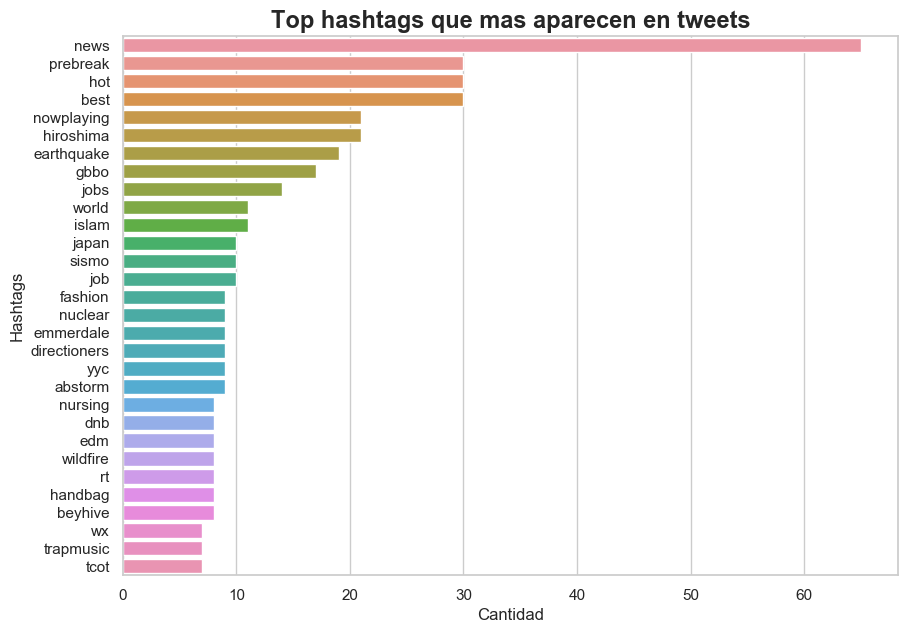

In [13]:
top_hashtags = hashtags_counts.head(30)
g = sns.barplot(x=top_hashtags.values, y=top_hashtags.index)
g.set_title("Top hashtags que mas aparecen en tweets", fontsize=17, fontweight='bold')
g.set_xlabel("Cantidad", fontsize=12)
g.set_ylabel("Hashtags", fontsize=12)

In [9]:
#tomo las palabras que empiezan con '@'
df_labels = df_palabras[df_palabras["words"].str.startswith('@')]
#junto las mismas palabras por si estan escritas en mayusculas y/o minusculas
df_labels["words"] = df_labels["words"].str.lower()
#quito los espacios de mas
df_labels["words"] = df_labels["words"].apply(lambda x: re.sub(' +',' ',x))
#quito los caracteres especiales que quedaron
df_labels["words"] = df_labels["words"].str.replace('_','')
df_labels["words"] = df_labels["words"].str.replace('@','')
df_labels["words"].value_counts().head(10)

youtube         83
                27
arianagrande    11
foxnews          9
change           9
potus            9
emmerdale        8
usatoday         8
justinbieber     7
djicemoon        7
Name: words, dtype: int64

In [10]:
 #me deshago de los arroba para no mostrarlos en la visualizacion
df_labels["words"] = df_labels["words"].str.replace('@','')
#quito el string vacio
labels_counts = df_labels["words"].value_counts()
labels_counts = labels_counts.drop(labels="")
labels_counts.head()

youtube         83
arianagrande    11
foxnews          9
change           9
potus            9
Name: words, dtype: int64

Text(0, 0.5, 'Usuarios')

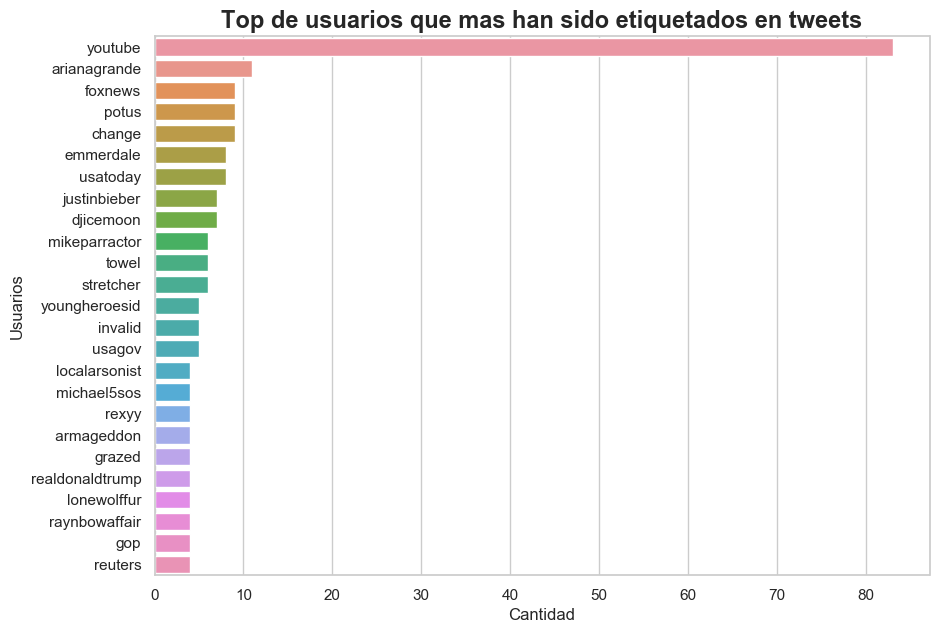

In [16]:
top_labels = labels_counts.head(25)
g = sns.barplot(x=top_labels.values, y=top_labels.index)
g.set_title("Top de usuarios que mas han sido etiquetados en tweets", fontsize=17, fontweight='bold')
g.set_xlabel("Cantidad", fontsize=12)
g.set_ylabel("Usuarios", fontsize=12)

In [11]:
#hago una limpieza del texto
#remuevo todos los caracteres no alfanumericos ni los '#@'
tweets["text"] = tweets["text"].str.lower()                                 #transformo todas las palabras a minusculas
tweets["text"] = tweets["text"].apply(lambda x: re.sub(r'[^\w#@]', ' ', x)) #remuevo todos los caracteres menos los alfanumericos ni los '#' y '@'
tweets["text"] = tweets["text"].apply(lambda x: re.sub(' +',' ',x))         #quito los espacios de mas
tweets["text"] = tweets["text"].str.replace('# ','')                        #quito los '#' que aparezcan solos
tweets["text"] = tweets["text"].str.replace('@ ','')                        #quito los '@' que aparezcan solos
tweets["text"] = tweets["text"].str.replace('_ ','')                        #quito los '_'

In [12]:
tweets["hashtag_count"] = tweets["text"].str.count('#')
tweets.head()

,id,keyword,location,text,target,hashtag_count
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,0
3,6,NaN,NaN,13 000 people receive #wildfires evacuation or...,1,1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,2


In [13]:
def concatenate(x,char):
    words = ""
    for word in x:
        if word.startswith(char):
            words = words + word + " "
    return words

In [14]:
#tweets["hashtags"] = tweets["text"].str.split(' ').apply(lambda x: [word for word in x if word.startswith('#')])
tweets["hashtags"] = tweets["text"].str.split(' ').apply(lambda x: concatenate(x,'#'))
tweets["labels_count"] = tweets["text"].str.count('@')
tweets["labels"] = tweets["text"].str.split(' ').apply(lambda x: concatenate(x,'@'))
tweets.head()

,id,keyword,location,text,target,hashtag_count,hashtags,labels_count,labels
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,1,#earthquake,0,
1,4,NaN,NaN,forest fire near la ronge sask canada,1,0,,0,
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,0,,0,
3,6,NaN,NaN,13 000 people receive #wildfires evacuation or...,1,1,#wildfires,0,
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,2,#alaska #wildfires,0,


In [15]:
tweets_con_hashtags = tweets[tweets["hashtag_count"] > 0]
len(tweets_con_hashtags)

1744

In [16]:
#filtro por target
tweets_falsos = tweets[tweets["target"]==0]
len(tweets_falsos)

4342

In [17]:
tweets_verdaderos = tweets[tweets["target"]==1]
len(tweets_verdaderos)

3271

In [18]:
df_palabras_v = pd.DataFrame(tweets_verdaderos["text"].str.split(' ', expand=True).stack(), columns=["words"])
df_palabras_f = pd.DataFrame(tweets_falsos["text"].str.split(' ', expand=True).stack(), columns=["words"])

In [19]:
df_hashtags_v = df_palabras_v[df_palabras_v["words"].str.startswith('#')]
df_hashtags_v["words"].value_counts().head(10)

#news          54
#hiroshima     22
#earthquake    19
#hot           13
#best          13
#prebreak      13
#japan         11
#yyc           10
#india         10
#worldnews      9
Name: words, dtype: int64

Text(0, 0.5, 'Hashtags')

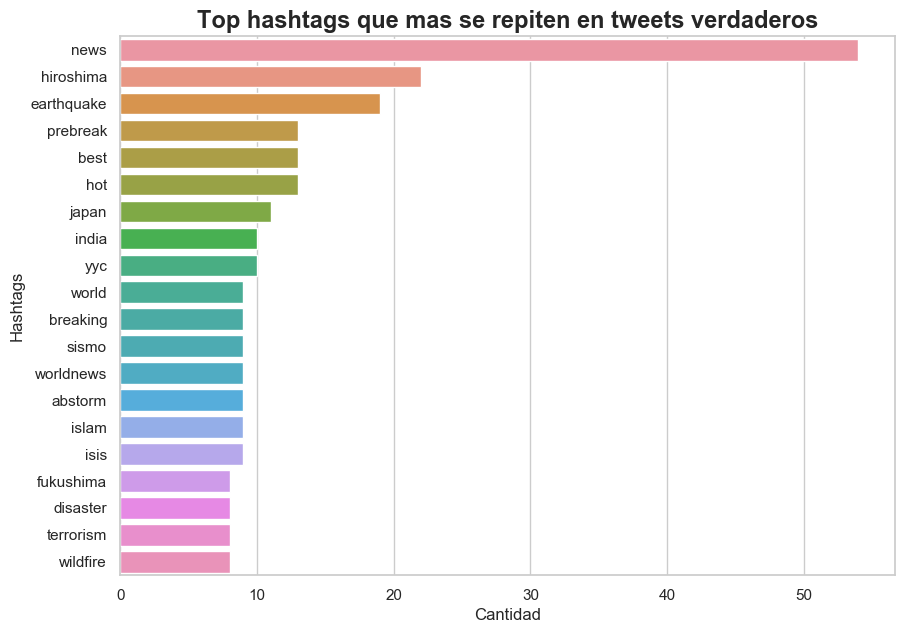

In [84]:
sin_hashtag = df_hashtags_v["words"].str.replace('#','')
top_hashtags = sin_hashtag.value_counts().head(20)
g = sns.barplot(x=top_hashtags.values, y=top_hashtags.index)
g.set_title("Top hashtags que mas se repiten en tweets verdaderos", fontsize=17, fontweight='bold')
g.set_xlabel("Cantidad", fontsize=12)
g.set_ylabel("Hashtags", fontsize=12)

In [20]:
df_hashtags_f = df_palabras_f[df_palabras_f["words"].str.startswith('#')]
df_hashtags_f["words"].value_counts().head(10)

#nowplaying    21
#news          20
#hot           17
#best          17
#prebreak      17
#jobs          14
#gbbo          14
#islam         14
#job           12
#hiring        10
Name: words, dtype: int64

Text(0, 0.5, 'Hashtags')

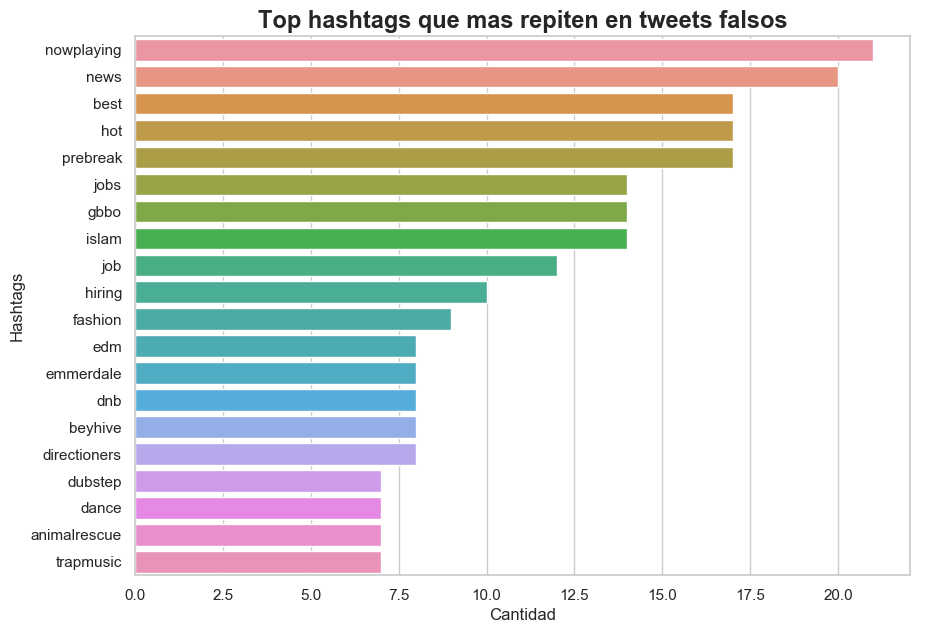

In [32]:
sin_hashtag = df_hashtags_f["words"].str.replace('#','')
top_hashtags = sin_hashtag.value_counts().head(20)
g = sns.barplot(x=top_hashtags.values, y=top_hashtags.index)
g.set_title("Top hashtags que mas repiten en tweets falsos", fontsize=17, fontweight='bold')
g.set_xlabel("Cantidad", fontsize=12)
g.set_ylabel("Hashtags", fontsize=12)

In [21]:
df_labels_v = df_palabras_v[df_palabras_v["words"].str.startswith('@')]
df_labels_v["words"].value_counts().head(10)

@youtube          18
@foxnews           8
@potus             6
@usagov            5
@ap                5
@change            4
@usatoday          4
@unsuckdcmetro     4
@michael5sos       3
@tflbusalerts      3
Name: words, dtype: int64

Text(0, 0.5, 'Usuarios')

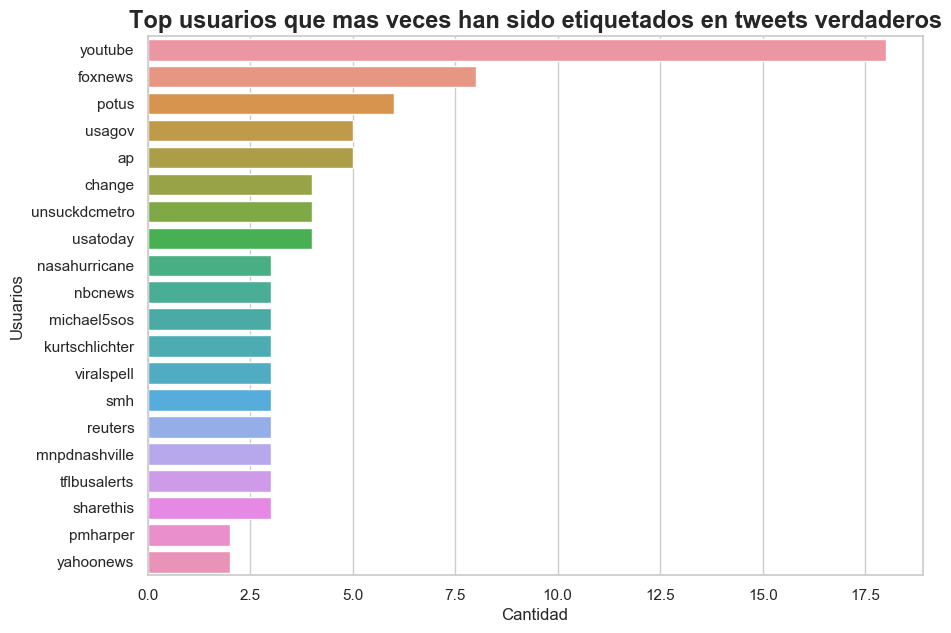

In [83]:
top_labels = df_labels_v["words"].str.replace('@','').value_counts().head(20)
g = sns.barplot(x=top_labels.values, y=top_labels.index)
g.set_title("Top usuarios que mas veces han sido etiquetados en tweets verdaderos", fontsize=17, fontweight='bold')
g.set_xlabel("Cantidad", fontsize=12)
g.set_ylabel("Usuarios", fontsize=12)

In [22]:
df_labels_f = df_palabras_f[df_palabras_f["words"].str.startswith('@')]
df_labels_f["words"].value_counts().head(10)

@youtube          65
@arianagrande     11
@emmerdale         7
@djicemoon         7
@justinbieber      7
@mikeparractor     6
@invalid           5
@towel             5
@change            5
@usatoday          5
Name: words, dtype: int64

Text(0, 0.5, 'Usuarios')

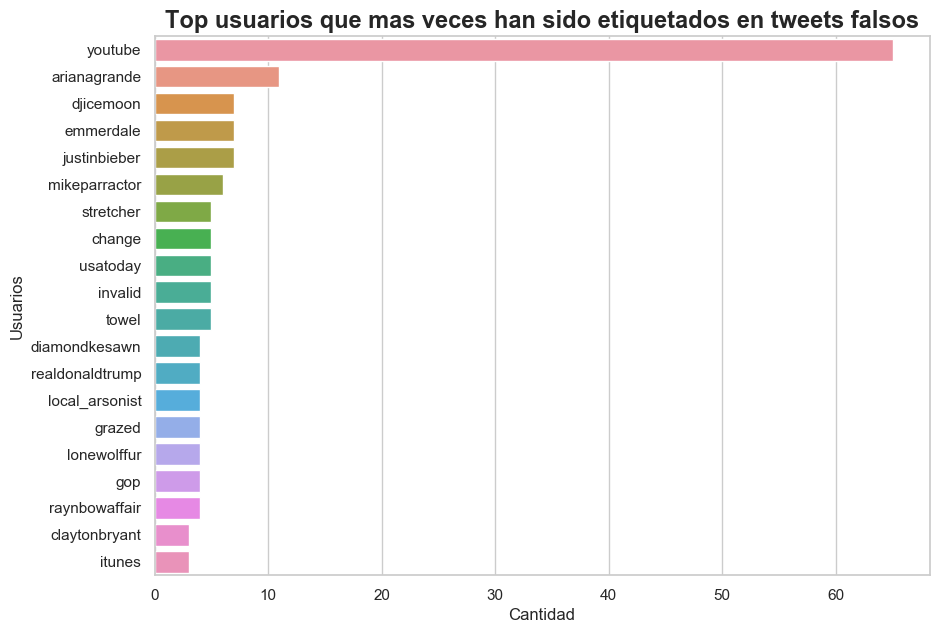

In [82]:
top_labels = df_labels_f["words"].str.replace('@','').value_counts().head(20)
g = sns.barplot(x=top_labels.values, y=top_labels.index)
g.set_title("Top usuarios que mas veces han sido etiquetados en tweets falsos", fontsize=17, fontweight='bold')
g.set_xlabel("Cantidad", fontsize=12)
g.set_ylabel("Usuarios", fontsize=12)

In [22]:
tweets.tail()    

,id,keyword,location,text,target,hashtag_count,hashtags,labels_count,labels
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1,0,,0,
7609,10870,NaN,NaN,@aria_ahrary @thetawniest the out of control w...,1,0,,2,@aria_ahrary @thetawniest
7610,10871,NaN,NaN,m1 94 01 04 utc 5km s of volcano hawaii http t...,1,0,,0,
7611,10872,NaN,NaN,police investigating after an e bike collided ...,1,0,,0,
7612,10873,NaN,NaN,the latest more homes razed by northern califo...,1,0,,0,


In [23]:
tweets_verdaderos = tweets[tweets["target"]==1]
tweetsV_con_HyL = tweets_verdaderos[(tweets_verdaderos["hashtag_count"]>0) & (tweets_verdaderos["labels_count"]>0)]
tweetsV_con_H = tweets_verdaderos[(tweets_verdaderos["hashtag_count"]>0) & (tweets_verdaderos["labels_count"]==0)]
tweetsV_con_L = tweets_verdaderos[(tweets_verdaderos["hashtag_count"]==0) & (tweets_verdaderos["labels_count"]>0)]
tweetsV_sin_nada = tweets_verdaderos[(tweets_verdaderos["hashtag_count"]==0) & (tweets_verdaderos["labels_count"]==0)]
print(len(tweetsV_con_HyL))
print(len(tweetsV_con_L))
print(len(tweetsV_con_H))
print(len(tweetsV_sin_nada))

130
537
729
1875


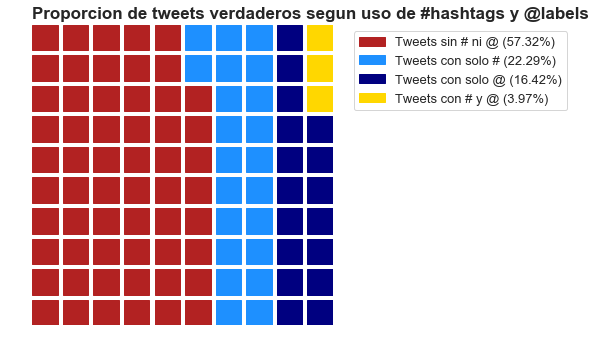

In [81]:
x = len(tweetsV_con_HyL)
y = len(tweetsV_con_L)
u = len(tweetsV_con_H)
v = len(tweetsV_sin_nada)
total = x + y + u + v
porcentajes = [round(v * 100/total, 2), round(u * 100/total, 2),\
               round(y * 100/total, 2), round(x * 100/total, 2)]
labels = ["Tweets sin # ni @ ({}%)".format(porcentajes[0]), "Tweets con solo # ({}%)".format(porcentajes[1]),\
            "Tweets con solo @ ({}%)".format(porcentajes[2]), "Tweets con # y @ ({}%)".format(porcentajes[3])]
fig = plt.figure(FigureClass = Waffle, figsize=(10,5), labels=labels, rows=10, values=porcentajes,\
                 colors=("firebrick", "dodgerblue", "navy", "gold"),\
                 legend={'loc': 'upper right', 'bbox_to_anchor': (1.8,1), 'fontsize': 13},\
                 title={'label': "Proporcion de tweets verdaderos segun uso de #hashtags y @labels",'loc': 'left', 'fontsize': 17, 'fontweight':'bold'})              

In [77]:
tweets_falsos = tweets[tweets["target"]==0]
tweetsF_con_HyL = tweets_falsos[(tweets_falsos["hashtag_count"]>0) & (tweets_falsos["labels_count"]>0)]
tweetsF_con_H = tweets_falsos[(tweets_falsos["hashtag_count"]>0) & (tweets_falsos["labels_count"]==0)]
tweetsF_con_L = tweets_falsos[(tweets_falsos["hashtag_count"]==0) & (tweets_falsos["labels_count"]>0)]
tweetsF_sin_nada = tweets_falsos[(tweets_falsos["hashtag_count"]==0) & (tweets_falsos["labels_count"]==0)]
print(len(tweetsF_con_HyL))
print(len(tweetsF_con_L))
print(len(tweetsF_con_H))
print(len(tweetsF_sin_nada))

221
1122
664
2335


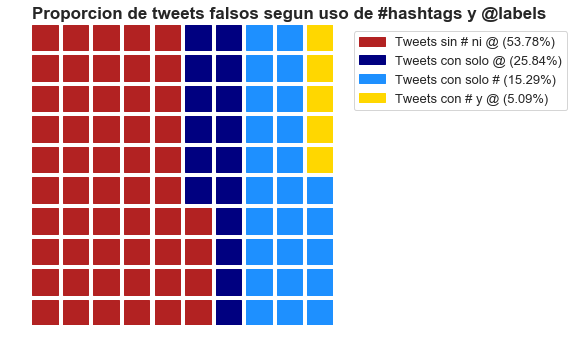

In [80]:
x = len(tweetsF_con_HyL)
y = len(tweetsF_con_L)
u = len(tweetsF_con_H)
v = len(tweetsF_sin_nada)
total = x + y + u + v
porcentajes = [round(v * 100/total, 2), round(u * 100/total, 2),\
               round(y * 100/total, 2), round(x * 100/total, 2)]
labels = ["Tweets sin # ni @ ({}%)".format(porcentajes[0]),"Tweets con solo @ ({}%)".format(porcentajes[2]),\
            "Tweets con solo # ({}%)".format(porcentajes[1]), "Tweets con # y @ ({}%)".format(porcentajes[3])]
fig = plt.figure(FigureClass = Waffle, figsize=(10,5), labels=labels, rows=10, values=porcentajes,\
                 colors=("firebrick", "navy", "dodgerblue", "gold"),\
                 legend={'loc': 'upper right', 'bbox_to_anchor': (1.8,1), 'fontsize': 13},\
                 title={'label': "Proporcion de tweets falsos segun uso de #hashtags y @labels",'loc': 'left', 'fontsize': 17, 'fontweight':'bold'})              

In [23]:
tweets.head()

,id,keyword,location,text,target,hashtag_count,hashtags,labels_count,labels
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,1,#earthquake,0,
1,4,NaN,NaN,forest fire near la ronge sask canada,1,0,,0,
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,0,,0,
3,6,NaN,NaN,13 000 people receive #wildfires evacuation or...,1,1,#wildfires,0,
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,2,#alaska #wildfires,0,


In [24]:
tweets.loc[:,["text","target","hashtags","hashtag_count"]].sort_values(by="hashtag_count", ascending=False).head(10)

,text,target,hashtags,hashtag_count
4468,no #news of #hostages in #libya http t co exil...,1,#news #hostages #libya #india #terrorism #afri...,13
7197,rare insight into #terror and how to fight it ...,1,#terror #cameroon #usa #whitehouse #es #fr #ni...,13
4483,no #news of #hostages in #libya http t co k9fb...,1,#news #hostages #libya #india #terrorism #afri...,13
4480,no #news of #hostages in #libya http t co bjjo...,1,#news #hostages #libya #india #terrorism #afri...,13
318,rt @rtrrtcoach #love #truelove #romance lith #...,0,#love #truelove #romance #voodoo #seduction #a...,11
312,rt @ophiuchus2613 #love #truelove #romance lit...,0,#love #truelove #romance #voodoo #seduction #a...,11
6626,truth https t co 4zqrsaqrrt #news #bbc #cnn #i...,1,#news #bbc #cnn #islam #truth #god #isis #terr...,10
6623,truth https t co k44tl3rfmy #news #bbc #cnn #i...,0,#news #bbc #cnn #islam #truth #god #isis #terr...,10
6618,truth https t co 2y4rgob7pj #news #bbc #cnn #i...,1,#news #bbc #cnn #islam #truth #god #isis #terr...,10
6602,truth https t co bejftygjil #news #bbc #cnn #i...,0,#news #bbc #cnn #islam #truth #god #isis #terr...,10


In [23]:
def twitter_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(198, 100%%, %d%%)" % random.randint(60,100)

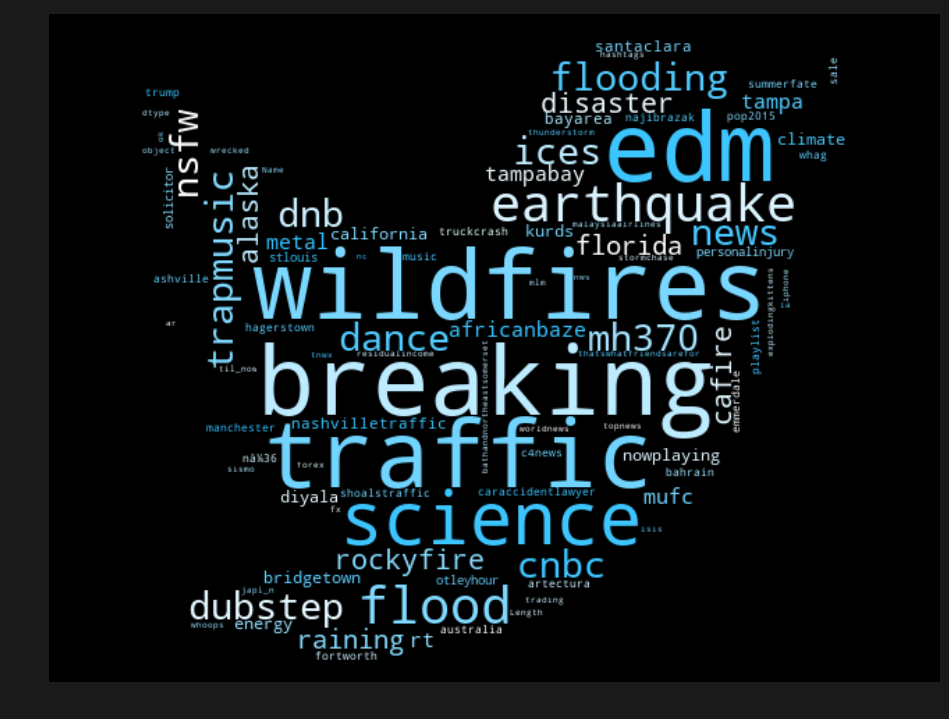

In [28]:
#wordclod sobre la columna de hashtags
mask = np.array(Image.open("../data/Twitter-Logo.jpg"))
wordcloud = WordCloud(width = 500, height = 500, min_font_size = 5, max_font_size = 70, max_words = 100, 
                      background_color = 'black',  mask= mask, stopwords = STOPWORDS).generate(str(tweets_con_hashtags["hashtags"]))
fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k')
plt.imshow(wordcloud.recolor(color_func = twitter_color_func, random_state=3), interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [26]:
tweets.loc[:,["text","target","labels","labels_count"]].sort_values(by="labels_count", ascending=False).head(10)

,text,target,labels,labels_count
3491,#cum explosion @begforcum @allday_cumshots @cu...,0,@begforcum @allday_cumshots @cumcovered @sexyc...,8
5383,@montetjwitter11 @mets @audreyp77 @teena_797 @...,0,@montetjwitter11 @mets @audreyp77 @teena_797 @...,7
551,ya boy clip vs 4kus full battle @15moferadio @...,0,@15moferadio @heavybag201 @battle_dom @qotring...,6
648,welcome @djryanwolf @djcoreygrand @djknyce @dj...,0,@djryanwolf @djcoreygrand @djknyce @djoneplust...,6
6311,@invalid @grazed @towel @stretcher @pllolz @wi...,0,@invalid @grazed @towel @stretcher @pllolz @wi...,6
135,anyone need a p u tonight i play hybrid slayer...,0,@cod8sandscrims @empirikgaming @codawscrims @4...,6
6305,@pllolz @grazed @stretcher @invalid @witter @t...,0,@pllolz @grazed @stretcher @invalid @witter @t...,6
3919,@creationmin @rwrabbit @gooneratheist @atheist...,0,@creationmin @rwrabbit @gooneratheist @atheist...,5
5744,@teamvodg discovered by @nickcannon listen buy...,0,@teamvodg @nickcannon @realmandyrain @itunesmu...,5
6313,@grazed @invalid @stretcher @rexyy @towel ben ...,0,@grazed @invalid @stretcher @rexyy @towel,5


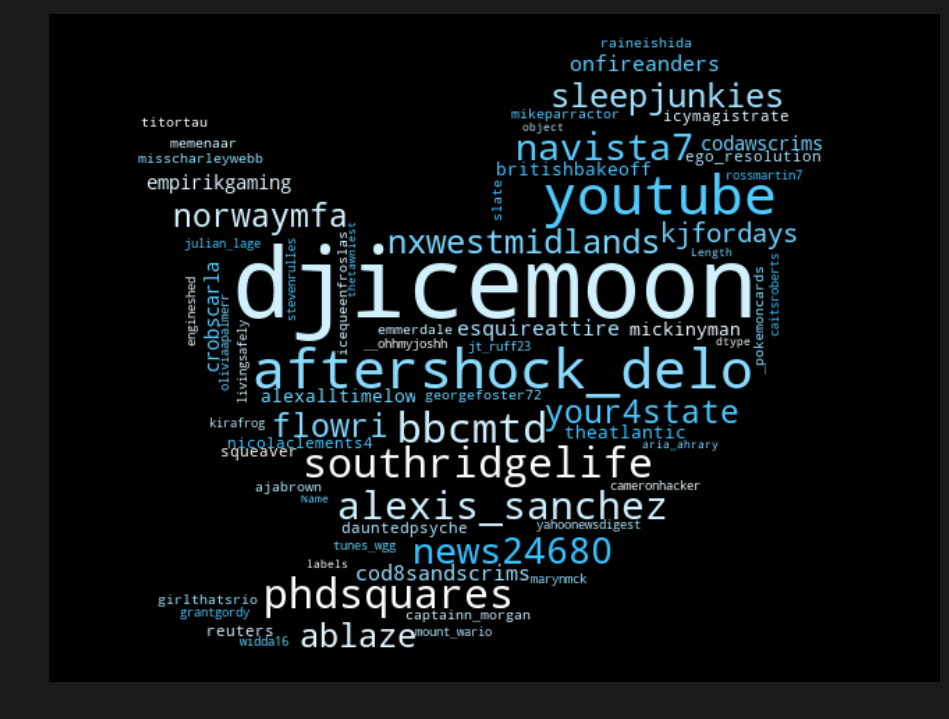

In [29]:
#hacer un wordcloud sobre la columna labels
tweets_con_labels = tweets[tweets["labels_count"]>0]
mask = np.array(Image.open("../data/Twitter-Logo.jpg"))
wordcloud = WordCloud(width = 500, height = 500, min_font_size = 5, max_font_size = 70, max_words = 100, 
                      background_color = 'black', mask=mask, stopwords = STOPWORDS).generate(str(tweets_con_labels["labels"]))
fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k')
plt.imshow(wordcloud.recolor(color_func = twitter_color_func, random_state=3), interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [95]:
#Estadisticas sobre uso de hashtags segun el target
grouped_by_target = tweets.groupby("target").agg({"hashtag_count":["mean","max","sum"],"labels_count":["mean","max","sum"]})
stacked = grouped_by_target.stack()
stacked

hashtag_count         labels_count
target                                               
0      mean                 0.39                 0.42
       max                 11.00                 8.00
       sum              1,691.00             1,827.00
1      mean                 0.50                 0.27
       max                 13.00                 5.00
       sum              1,644.00               892.00

In [36]:
tweets_con_keywords = tweets[~tweets["keyword"].isnull()]
top20_keywords = tweets["keyword"].value_counts().head(20).index.tolist()
tweets_top20_keywords = tweets[tweets["keyword"].isin(top20_keywords)]
tweets_top20_keywords["keyword"].value_counts()

fatalities     45
armageddon     42
deluge         42
harm           41
damage         41
sinking        41
body%20bags    41
fear           40
siren          40
collided       40
windstorm      40
evacuate       40
twister        40
outbreak       40
derailment     39
weapon         39
wrecked        39
weapons        39
wreckage       39
hellfire       39
Name: keyword, dtype: int64

In [37]:
tweets_top20_keywords.groupby(["target","keyword"]).agg({"hashtag_count":["mean","max","sum"],"labels_count":["mean","max","sum"]})

hashtag_count                 labels_count        
                                   mean max sum                 mean max sum
target keyword                                                              
0      armageddon                  1.43  11  53                 0.51   3  19
       body%20bags                 0.30   7  12                 0.25   4  10
       collided                    0.59   4  10                 0.59   3  10
       damage                      0.45   6  10                 0.73   3  16
       deluge                      0.56   3  20                 0.47   3  17
       evacuate                    0.40   3   6                 0.13   1   2
       fatalities                  0.26   2   5                 0.32   2   6
       fear                        0.37   5  13                 0.34   4  12
       harm                        0.14   2   5                 0.41   2  15
       hellfire                    0.69   5  22                 0.31   2  10
       outbreak                    0.00   0   0                 1.00   1   1
       sinking                     0.21   2   7                 0.24   2   8
       siren                       0.11   1   4                 0.57   3  20
       twister                     0.14   2   5                 0.51   3  18
       weapon                      0.20   2   5                 0.44   2  11
       weapons                     0.73   4  16                 0.73   2  16
       windstorm                   0.79   3  19                 0.12   1   3
       wrecked                     0.36   3  13                 0.36   3  13
1      armageddon                  1.00   3   5                 0.20   1   1
       body%20bags                 0.00   0   0                 2.00   2   2
       collided                    0.26   2   6                 0.00   0   0
       damage                      0.42   3   8                 0.58   3  11
       deluge                      0.33   1   2                 0.17   1   1
       derailment                  0.36   3  14                 0.15   2   6
       evacuate                    0.56   6  14                 0.20   1   5
       fatalities                  0.31   2   8                 0.31   3   8
       fear                        0.00   0   0                 0.20   1   1
       harm                        0.25   1   1                 0.50   1   2
       hellfire                    1.29   5   9                 0.29   2   2
       outbreak                    0.23   3   9                 0.08   1   3
       sinking                     0.12   1   1                 0.12   1   1
       siren                       0.20   1   1                 0.40   1   2
       twister                     0.40   1   2                 0.00   0   0
       weapon                      1.14  13  16                 0.07   1   1
       weapons                     0.76   5  13                 0.29   2   5
       windstorm                   0.50   2   8                 0.19   1   3
       wreckage                    0.23   3   9                 0.08   1   3
       wrecked                     0.00   0   0                 0.67   2   2